## 📊 Projeto – Stacking Regressão

Uma **HealthTech** realizou uma pesquisa com mais de 1.300 pessoas sobre gastos realizados com saúde nos últimos 2 anos para criar uma oferta mais assertiva de planos de saúde para pequenas e médias empresas. Dentre os componentes para formatar esta oferta, é importante conseguir estimar os gastos de saúde dos funcionários de uma possível empresa cliente, com base em algumas características destes funcionários.

Desta forma, para apoiar no desenvolvimento desta oferta, iremos trabalhar num **algoritmo de regressão** que possa **estimar os gastos de saúde de funcionários**. Considerando o volume de dados e as features disponíveis, adotaremos o **método Stacking de ensemble, usando algoritmos supervisionados de regressão**.

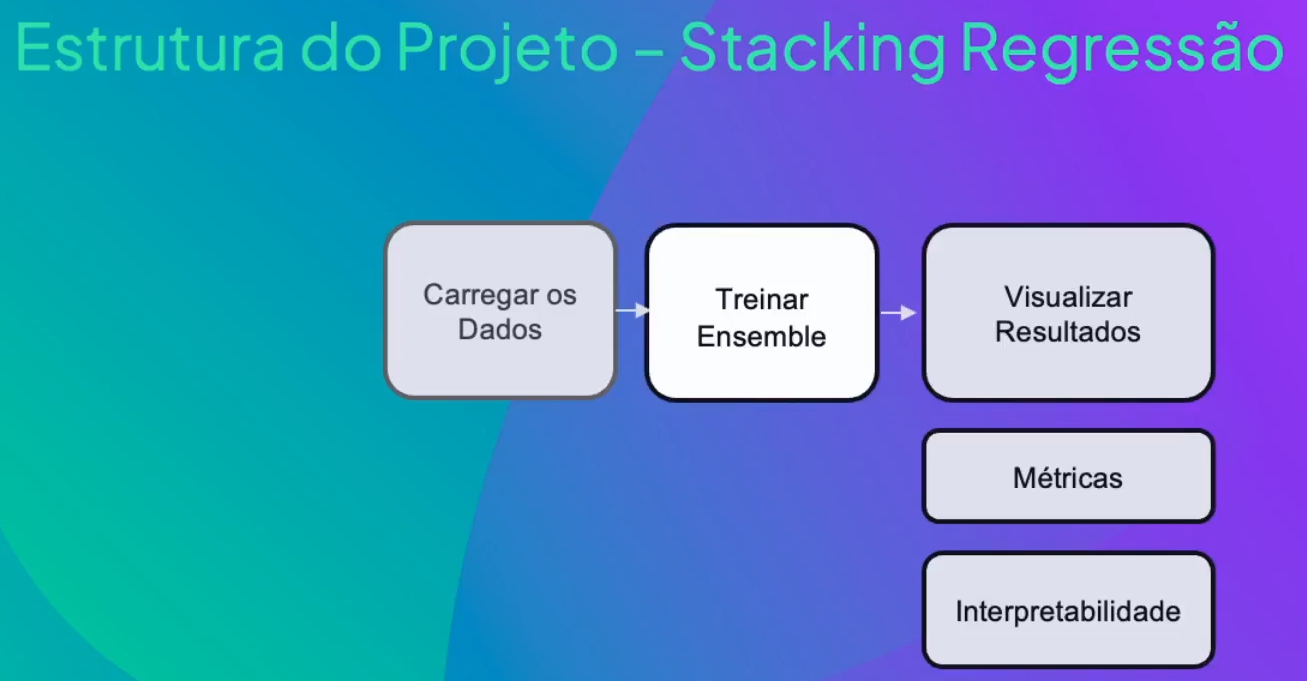

In [1]:
# Importar as bibliotecas

# EDA
import pandas as pd
import plotly.express as px
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

### Carregar Dados

In [2]:
# Carregar os dados ja tratados
df_costs = pd.read_csv('./datasets/healthcosts_cleaned.csv')

In [3]:
# Mostrar as primeiras linhas
df_costs.head(20)

,age,sex,bmi,children,smoker,region,medical charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
5,31,female,25.740,0,0,southeast,3756.62160
6,46,female,33.440,1,0,southeast,8240.58960
7,37,female,27.740,3,0,northwest,7281.50560
8,37,male,29.830,2,0,northeast,6406.41070
9,60,female,25.840,0,0,northwest,28923.13692


In [4]:
# Mostrar as ultimas linhas
df_costs.tail(20)

,age,sex,bmi,children,smoker,region,medical charges
1318,35,male,39.710,4,0,northeast,19496.71917
1319,39,female,26.315,2,0,northwest,7201.70085
1320,31,male,31.065,3,0,northwest,5425.02335
1321,62,male,26.695,0,1,northeast,28101.33305
1322,62,male,38.830,0,0,southeast,12981.34570
1323,42,female,40.370,2,1,southeast,43896.37630
1324,31,male,25.935,1,0,northwest,4239.89265
1325,61,male,33.535,0,0,northeast,13143.33665
1326,42,female,32.870,0,0,northeast,7050.02130
1327,51,male,30.030,1,0,southeast,9377.90470


In [5]:
# Mostrar a estrutura do dataset
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1338 non-null   int64  
 1   sex              1338 non-null   object 
 2   bmi              1338 non-null   float64
 3   children         1338 non-null   int64  
 4   smoker           1338 non-null   int64  
 5   region           1338 non-null   object 
 6   medical charges  1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


### Preparação dos dados

In [6]:
# Preparar os dados para o modelo
X = df_costs.drop(columns=['medical charges'])
y = df_costs['medical charges']

In [7]:
# Carregar preprocessor
import joblib
preprocessor = joblib.load('./preprocessor_dataset_healthcosts.pkl')

In [8]:
# Dividir o dataset entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [9]:
# Aplicar o preprocessor em treinamento e teste
# Treinamento = fit & transform
# Teste = transform, considerando o treinamento que foi feito anteriormente
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [10]:
# Mostrar as dimensoes dos conjuntos
print(f'Treinamento: {X_train.shape}')
print(f'Teste: {X_test.shape}')

Treinamento: (1070, 10)
Teste: (268, 10)


### Treinamento do Modelo Stacking

In [11]:
# Criar o modelo de Stacking Regressor

# Algoritmos base
lr_model = LinearRegression()
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=51)
tree_model = DecisionTreeRegressor(random_state=51)

# Meta-modelo ou Meta-learner
huber_model = HuberRegressor()

# Stacking Modelo
stacking_model = StackingRegressor(
    estimators = [
        ('linear regression', lr_model),
        ('elastic', elastic_model),
        ('decision tree', tree_model),
    ],
    final_estimator=huber_model,
    # Passthrough = False (padrao) -> Usa apenas as predicoes dos estimadores
    # Passthrough = True -> Usa as predicoes dos estimadores + conjunto de treinamento (dataset)
    passthrough=False
)

In [12]:
# Treinar o modelo
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('linear regression', LinearRegression()),
                              ('elastic', ElasticNet(random_state=51)),
                              ('decision tree',
                               DecisionTreeRegressor(random_state=51))],
                  final_estimator=HuberRegressor())

### Análise de Resultados

In [13]:
# Fazer as predicoes com base no modelo treinado
y_pred = stacking_model.predict(X_test)

In [14]:
# Mostrar as predicoes
y_pred

array([ 7695.79959725, 43370.93405492, 20538.5337199 , 23306.79628201,
       38542.87992824,  9712.19066585,  7864.68467423, 12191.71869977,
        5530.5934329 ,  9405.74504414,  8707.54848159, 11508.65098615,
        7327.30156712,  2463.04849912,  4553.46990533, 12495.95535168,
        3100.39761183,  6935.23743426, 18344.04697192, 20101.55089449,
        4888.24901415,  6829.38484692, 53567.50549202, 10875.11501712,
        5634.50271864, 15015.90063325, 11475.01694231,  1573.00910167,
       30832.39007448, 19316.03404105,  1437.97164139, 23004.37525715,
        2486.96709227,  2806.40056812,  7060.57244398, 24988.87749613,
        7348.17486445,  1418.96078898, 11657.23837065,  7247.37658504,
       11211.77968941,  1234.95208952,  3676.24582514,  1443.33461362,
       12248.44036694, 12752.26062901, 11556.60219094, 40223.96058083,
        8302.20504108, 12560.89421783,  4744.64392108, 37488.43146823,
        8832.32557457, 46791.81649497, 18839.48431266, 33244.72604585,
      

In [15]:
# Avaliar metricas do modelo
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

In [16]:
# Mostrar o Erro e R2 do modelo
print(f'Root Mean Squared Error: {rmse}')
print(f'R2: {r2}')

Root Mean Squared Error: 6641.236668309561
R2: 0.7463459096736079


In [17]:
# Calcular a importancia considerando os modelos do Stacking Regressor

importances = []

for estimador in stacking_model.estimators_:
    if hasattr(estimador, 'coef_'):
        # Uso em modelos lineares
        importances.append(np.abs(estimador.coef_))
    elif hasattr(estimador, 'feature_importances_'):
        # Uso em modelos de arvore
        importances.append(estimador.feature_importances_)
    else:
        print(f'Não foi possível carregar a importância das variáveis do modelo {type(estimator).__name__}')

In [18]:
# Calcular a media das importancias
importancia_media = np.mean(importances, axis=0)

In [20]:
# Normalizar as importancias
feature_importance = importancia_media / np.sum(importancia_media)

In [21]:
# Obter os nomes das features
feature_names = preprocessor.get_feature_names_out()

In [26]:
# Criar um dataframe com as importancias e os nomes das features
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

In [28]:
# Ordenar o dataframe pela importancia
importance_df = importance_df.sort_values(by='importance', ascending=True)

In [29]:
# Criar o gráfico de barras para apresentar a importância das features
fig = px.bar(importance_df,
    x='importance',
    y='feature',
    title='Importância das Features – Stacking Regressor',
    orientation='h'
)

fig.show()

### Propriedades do Modelo

In [30]:
# Mostrar a evidencia do Stacking Regressor

# Selecionar uma amostra para fazer a predicao
X_sample = X_test[7].reshape(1, -1)

# Predicoes individuais dos estimadores
linear_pred = stacking_model.named_estimators_['linear regression'].predict(X_sample)
elastic_pred = stacking_model.named_estimators_['elastic'].predict(X_sample)
tree_pred = stacking_model.named_estimators_['decision tree'].predict(X_sample)

# Predicao final do Stacking Regressor
stacking_pred = stacking_model.predict(X_sample)

In [31]:
# Mostrar predições
print(f'Predição da Regressão Linear: {linear_pred[0]}')
print(f'Predição do ElasticNet: {elastic_pred[0]}')
print(f'Predição da Árvore de Decisão: {tree_pred[0]}')

print(f'Predição final do Stacking Regressor: {stacking_pred[0]}')

Predição da Regressão Linear: 14793.194288532955
Predição do ElasticNet: 13782.690606341423
Predição da Árvore de Decisão: 11856.4115
Predição final do Stacking Regressor: 12191.718699771449
